# FNN Project: Predicting Taxi Driver Tips
## David, Dongyue, and Sam 

By the time a taxicab has arrived at it's passengers' destination, the taxi's information system will have collected a varity of data reflecting ride characteristics. Pickup time, location, trip duration, number of passenegers, surcharges, tolls and more manifest in datasets containing the characteristics of the tens of millions of taxi rides taken each year by New Yorkers. These characteristics are, for the most part, known to drivers before they complete their trip; drivers can estimate trip duration and can predict any tolls they might face on the way. Most prediction has, importantly, attempted to analyse the effect of these various factors on taxi fare ammounts. Yet, fares fail to paint the full picture. Until the completion of a trip, taxi drivers remain uncertain about their trip earnings as they wait for tipped wages to factor in. 

Taxi drivers depend on tips for approximately 17% of their taxi based income. Since there is wide variation in tipping across types of trips and customres, there is reason to value predictions about tipped ammounts. Better predictions of tipped ammounts should enable taxi-drivers to better allocate their services and maximise revenue. If we choose to understand tipping as a factor of the consumer surplus implicit in a trip, then tipped ammounts might be an indicator of potential improvements to other fare models that do not include tips. Lastly, in the long term, models that predict tipping might serve as coal-mine canaries for a possible dying tipping culture.

# The Data

We will use data from Google BigQuery about taxi trips taken by [NYC yellow cabs in 2016](https://console.cloud.google.com/bigquery?project=enduring-plate-219216&p=bigquery-public-data&d=new_york_taxi_trips&t=tlc_yellow_trips_2016&page=table).

Since we are going to predict the tips for taxi drivers in our project, we will use tip_amount variable as our response variable. Then, we will use variables including fare_amount, pickup_datetime, pick_up location, dropoff_location, passenger_count, trip_distance, rate_code, extra, payment_type as our explanatory variable to predict the tip a taxi driver will receive for his trip.
- `Fare_amount`: The fare amount variable is the fundemental for how much tip a driver will get because in many cases, the tip amount is calculated as a percentage of the fare amount.
- `Pickup_datetime`: The pick date and time can be influencial to the tip amount passenger are willing to pay based on different time period in a week or in a day. In this case, we use CAST function to filter out weekday, day, and hour as identical variable and test their relationships with tip amount separetly.
- `Pick_up location` & `Dropoff_location`: These variable include precise longtitude and latitude information for pickup and dropoff location. It will be interested to see if there is connections between location and tip amount.
- `Trip_distance`: longer trip may have negative effect on the tip amount because longer trips means higher fare. However, this is something that we needs to prove.

We also conditioned on several variables to ensure we had substantively meaninful observations.
- `Rate_code`: We limit the rate code to "1", which represents the standard rate. We will only use the standard rate for our further analysis, since we are only interested in the large sample of tips from standard rides.
- `Payment_type`: We set the payment type equals to "1" which indicates the card payment. The reason what just keep card payment is that the information of tips can be only found with card payments.



In [107]:
import google.datalab.bigquery as bq
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [113]:
%%bq tables describe
name: bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016

## Data Query and Sampling

After we chose to explore these variables, we used the query below to retrieve the data. When selecting the variables of interest we extracted the weekday, day, and hour separately from the original timestamp `pickup_datetime`. We also casted these variables to strings so they can be used as categorical features. To try and ensure that all of our observations were substantively meaningful and represented real taxi rides, we also included several `WHERE` clauses in the query. We limited the fare_amount to be between 2 and 200 because observations with fares beyond those bounds seem more likely to be errors than actual taxi rides. We also excluded observations that had null values for the pickup and dropoff locations (longitude and latitude). Finally, we limited `payment_type` to credit cards (type 1). This was necessary because the data set only includes the tip amount for riders who paid with credit cards as cash tips are not recorded. This is an unfortunate limitation of our model as it will not be able to predict cash tips.

In [114]:
%%bq query --name taxi_query
SELECT 
  fare_amount,
  CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM pickup_datetime) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) as hour,
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude,
  passenger_count,
  trip_distance,
  rate_code, 
  extra,
  payment_type,
  tip_amount
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE 
  fare_amount > 2.0 AND fare_amount < 200.0 AND
  rate_code = 1 AND #only standard rates
  payment_type = '1' AND #only select observations when passengers paid with credit cards 
  pickup_latitude IS NOT NULL AND
  pickup_longitude IS NOT NULL AND
  dropoff_latitude IS NOT NULL AND
  dropoff_longitude IS NOT NULL

Once we had our query, we sampled 0.3% of the data and casted it to a pandas dataframe. A 0.3% sample allowed us to have with over 100,000 cases in the training set and several thousand in the test set. Using a pandas dataframe allowed us to use the tools we have already learned to investigate and visualize our data.

In [72]:
# Sample 0.3% data, and split it into train/eval sets
sampling = bq.Sampling.random(percent=0.3)
job = taxi_query.execute(sampling=sampling)
result=job.result()

In [73]:
df = result.to_dataframe()

After we created a dataframe from the query results, we sorted the data by `tip_amount` and printed out the five obersvations with the five highest tips.

In [115]:
df.sort_values(by="tip_amount", ascending=False).head(10)

,fare_amount,weekday,day,hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance,rate_code,extra,payment_type,tip_amount
78558,14.0,5,154,16,40.737030,-73.988724,40.668369,-73.789383,2,0.03,1,1.0,1,280.0
54570,150.0,1,157,12,40.761539,-73.982742,40.668461,-73.789970,2,16.64,1,0.0,1,140.0
39860,2.5,3,82,10,0.000000,0.000000,40.815289,-74.359108,2,0.00,1,0.0,1,112.0
78914,55.0,4,167,16,40.768776,-73.862892,40.757366,-73.983337,4,11.71,1,1.0,1,70.0
1094,2.5,1,45,0,40.769878,-73.994217,40.770462,-73.994339,1,0.10,1,0.5,1,65.0
262,7.5,3,12,0,40.748409,-73.987701,40.756748,-73.974579,1,1.50,1,0.5,1,55.0
78104,66.0,2,137,16,40.773994,-73.873528,40.724018,-73.588112,1,22.85,1,1.0,1,55.0
54964,56.0,7,170,12,40.750828,-73.975403,40.687927,-74.183113,1,17.50,1,0.0,1,54.0
101759,2.5,5,147,19,0.000000,0.000000,0.000000,0.000000,1,0.00,1,1.0,1,50.0
7047,43.0,4,104,1,40.750343,-73.982529,40.622116,-74.031616,1,13.90,1,0.5,1,50.0


We then started examining the distribution of `tip_amount` by using the seabon package to create a density plot. The data is obviously extremely right skewed, with most observations clustered where tips are under $10.

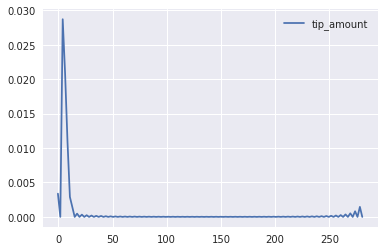

In [147]:
sns.kdeplot(df.tip_amount)

We then clipped the x-axis to examine those observations with tips under $\$$10. 
The data is still largely right-skewed, with two peaks at $\$$1 and $\$$2.

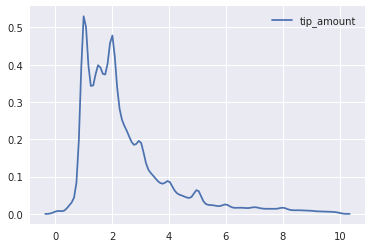

In [117]:
sns.kdeplot(df.tip_amount, clip=(0,10))

In [166]:
#ax = df.groupby('passenger_count').tip_amount.mean().plot.barh()
#ax.set_xlabel('Average Tip Amount')
#ax.set_ylabel('Number of Passengers')

In [78]:
#plt.subplots(figsize=(18,14))
#sns.boxplot(x="payment_type", y="tip_amount", data=df)
#plt.boxplot(df.tip_amount)

We also wanted to examine how some of our features mapped onto the tip amount. One feature we thought would be strongly associated with how much people tip was the length of the trip. To examine this we used the `sns.lmplot` function to examine the relationship between `tip_amount` and `trip_distance`.

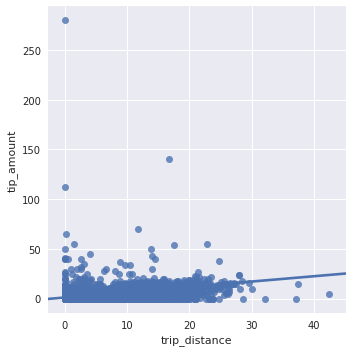

In [119]:
sns.lmplot("trip_distance", "tip_amount", data=df)

In [121]:
msk = np.random.rand(len(df)) < 0.95
train_df = df[msk]
eval_df = df[~msk]

In [122]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 127646 instances.
Eval set includes 6834 instances.


## Save Data

After splitting the data into train and eval sets, we saved both sets of the data for model training.

In [124]:
!mkdir -p ./taxitip

In [123]:
train_df.to_csv('./taxitip/train.csv', header=False, index=False)
eval_df.to_csv('./taxitip/eval.csv', header=False, index=False)

## Creating a Model

Prior to creating our predictions, we created a scema for the various variables of interest. We defined the appropriate category type for each variable while creating the dataset and then set transform to scale, one-hot, identity, or target for the analyze command. We then created a DNN regression model using 200 hidden layers. We used a large number of layers in order to account for the large number of features we were using to predict the target, (`tip_amount`).

In [112]:
# This loads %%ml commands
import google.datalab.contrib.mlworkbench.commands

In [86]:
ml dataset create
format: csv
train: ./taxitip/train.csv
eval: ./taxitip/eval.csv
name: taxitip_data
schema:
    - name: tip_amount
      type: FLOAT
    - name: fare_amount
      type: FLOAT
    - name: weekday
      type: STRING
    - name: day
      type: STRING
    - name: hour
      type: STRING
    - name: pickup_latitude
      type: FLOAT
    - name: pickup_longitude
      type: FLOAT
    - name: dropoff_latitude
      type: FLOAT
    - name: dropoff_longitude
      type: FLOAT
    - name: passenger_count 
      type: FLOAT
    - name: trip_distance 
      type: FLOAT               
    - name: rate_code 
      type: STRING
    - name: extra 
      type: FLOAT               
    - name: payment_type
      type: STRING  

In [126]:
%%ml dataset explore --overview
name: taxitip_data

train data instances: 127646
eval data instances: 6834
Sampled 1000 instances for each.


# Feature Design

This final model has a large number of features. Throughout this project we developed several specifications of the model. Originally, we were hoping to develop a more parsimonious model that relied on fewer features. However, when we trained these models they did not perform well. The mean squared error and 90 percentile absolute error (see below) skyrocketed and the individual predictions they produce were substantively ridiculus (e.g. a predicted `tip_amount` of -200 dollars).  In order to have a model that worked well overall (had low error), we used all of the features in our analysis and training.

In [125]:
# Delete previous run results.
!rm -r -f ./taxitip/analysis 

In [89]:
%%ml analyze --output ./taxitip/analysis 
data: $taxitip_data
features:
  tip_amount:
    transform: target 
  fare_amount:
    transform: identity 
  weekday:
    transform: one_hot
  day:
    transform: one_hot
  hour:
    transform: one_hot
  pickup_latitude:
    transform: scale    
  pickup_longitude:
    transform: scale
  dropoff_latitude:
    transform: scale
  dropoff_longitude:
    transform: scale
  passenger_count:
    transform: identity
  trip_distance:
    transform: identity
  rate_code:
    transform: one_hot
  extra:
    transform: identity
  payment_type:
    transform: one_hot

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_regression_taxi/taxitip/train.csv...
file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_regression_taxi/taxitip/train.csv analyzed.


In [1]:
# Delete previous run results.
!rm -r -f ./taxitip/train 

### DNN Regression Model

In [ ]:
%%ml train
output: ./taxitip/train
analysis: ./taxitip/analysis
data: taxitip_data
model_args:
    model: dnn_regression
    hidden-layer-size1: 200

TensorBoard was started successfully with pid 12451. Click here to access it.

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


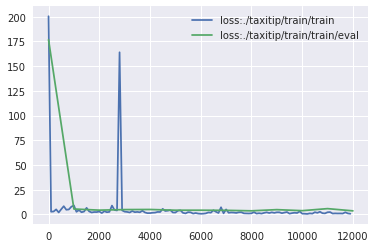

In [111]:
from google.datalab.ml import Summary
summary = Summary('./taxitip/train')
summary.plot('loss')

## Batch prediction

In [127]:
!rm -r -f ./taxitip/batch_predict # Delete previous results.

In [175]:
!ls ./taxitip/train/

evaluation_model  model  schema_without_target.json  train


In [110]:
%%ml batch_predict
model: ./taxitip/train/evaluation_model/
output: ./taxitip/batch_predict
format: csv
data:
  csv: ./taxitip/eval.csv    

local prediction...
INFO:tensorflow:Restoring parameters from ./taxitip/train/evaluation_model/variables/variables
done.


In [176]:
!ls ./taxitip/batch_predict

predict_results_eval.csv  predict_results_schema.json


In [108]:
%%ml evaluate regression
csv: ./taxitip/batch_predict/predict_results_eval.csv

,metric,value
0,Root Mean Square Error,1.908909
1,Mean Absolute Error,1.220663
2,50 Percentile Absolute Error,0.756683
3,90 Percentile Absolute Error,2.829838
4,99 Percentile Absolute Error,6.993448


In [165]:
%%ml evaluate accuracy
csv: ./taxitip/batch_predict/predict_results_eval.csv

Based on the metrics produced when we evaluated the regression, our model seems to be pretty good at predicting the amount a passenger will tip their taxi driver. In particular, the 90 Percentile Absolute Error is pretty low at 2.82. This seems to be a substantively meaningful metric because it represents the error in 9 out of 10 cases. To a cab driver, predicting how big of a tip they will receive 9 out of every 10 times they took a given trip within less than $\$$3 would be a really helpful model.

## Prediction

Now we use the non-evaluation model (./taxitip/train/model) which does not take the target column as an input. First, we took the prediction data from the eval csv file. Using these datapoints without the target column (`tip_amount`). 

In [152]:
%%ml predict
model: ./taxitip/train/model/
data:
  - 33.0,1,59,0,40.75135040283203,-73.9943618774414,40.66524887084961,-73.95893096923828,1,8.05,1,0.5,1
  - 8.5,1,59,0,40.740299224853516,-73.9857177734375,40.76605987548828,-73.96961212158203,1,2.1,1,0.5,1
  - 26.0,1,59,0,40.79415512084961,-73.96676635742188,40.73012161254883,-73.99850463867188,1,6.9,1,0.5,1
  - 32.5,1,59,0,40.76390075683594,-73.98169708251953,40.67359924316406,-73.95841979980469,1,9.93,1,0.5,1
  - 17.5,1,59,0,40.7047004699707,-74.01502990722656,40.73240661621094,-73.98705291748047,1,4.67,1,0.5,1

predicted,day,dropoff_latitude,dropoff_longitude,extra,fare_amount,hour,passenger_count,payment_type,pickup_latitude,pickup_longitude,rate_code,trip_distance,weekday
14.013005,59,40.66524887084961,-73.95893096923828,0.5,33.0,0,1,1,40.75135040283203,-73.9943618774414,1,8.05,1
11.005036,59,40.76605987548828,-73.96961212158203,0.5,8.5,0,1,1,40.740299224853516,-73.9857177734375,1,2.1,1
12.743536,59,40.73012161254883,-73.99850463867188,0.5,26.0,0,1,1,40.79415512084961,-73.96676635742188,1,6.9,1
15.019936,59,40.67359924316406,-73.95841979980469,0.5,32.5,0,1,1,40.76390075683594,-73.98169708251953,1,9.93,1
11.867023,59,40.73240661621094,-73.98705291748047,0.5,17.5,0,1,1,40.7047004699707,-74.01502990722656,1,4.67,1


It seems that, while the model does very well overall when evaluated by the 90 Percentile Absolute Error, it may not do as well on individual observations. It is possible that this has to do with the extremely right-skewed distribution we originally saw during the data exploration we did using `pandas`. However, while these predicted tip amounts are larger than the real values they are still relatively realistic values for someone to tip a cab driver.

One factor we were interested in was how different amount of passengers would tip their drivers. As one way to look at this, we used manipulated the passenger count while predicting with our model. We used the model to predict the tip amount for a hypothetical trip where all values were set to their measures of central tendency (either median or mean) except for passenger count.

In [170]:
print(df.fare_amount.mean())
print(df.weekday.median())
print(df.day.median())
print(df.hour.median())
print(df.pickup_latitude.median())
print(df.pickup_longitude.median())
print(df.dropoff_latitude.median())
print(df.dropoff_longitude.median())
print(df.rate_code.median())
print(df.extra.mean())

12.125102840571088
4.0
91.0
14.0
40.7527370453
-73.9820556641
40.7528972626
-73.9800720215
1.0
0.33459287626412854


1.0

In [177]:
%%ml predict
model: ./taxitip/train/model/
data:
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 0.3, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 2, 2.7, 1, 0.3, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 3, 2.7, 1, 0.3, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 4, 2.7, 1, 0.3, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 5, 2.7, 1, 0.3, 1

predicted,day,dropoff_latitude,dropoff_longitude,extra,fare_amount,hour,passenger_count,payment_type,pickup_latitude,pickup_longitude,rate_code,trip_distance,weekday
11.460565,91,40.75,-73.98,0.3,12,14,1,1,40.75,-73.98,1,2.7,4
13.527218,91,40.75,-73.98,0.3,12,14,2,1,40.75,-73.98,1,2.7,4
16.454340,91,40.75,-73.98,0.3,12,14,3,1,40.75,-73.98,1,2.7,4
19.388260,91,40.75,-73.98,0.3,12,14,4,1,40.75,-73.98,1,2.7,4
22.392479,91,40.75,-73.98,0.3,12,14,5,1,40.75,-73.98,1,2.7,4


In [173]:
%%ml predict
model: ./taxitip/train/model/
data:
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 0.25, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 0.5, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 1, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 3, 1
  - 12, 4, 91, 14, 40.75, -73.98, 40.75, -73.98, 1, 2.7, 1, 5, 1

predicted,day,dropoff_latitude,dropoff_longitude,extra,fare_amount,hour,passenger_count,payment_type,pickup_latitude,pickup_longitude,rate_code,trip_distance,weekday
11.442221,91,40.75,-73.98,0.25,12,14,1,1,40.75,-73.98,1,2.7,4
11.533942,91,40.75,-73.98,0.5,12,14,1,1,40.75,-73.98,1,2.7,4
11.717923,91,40.75,-73.98,1,12,14,1,1,40.75,-73.98,1,2.7,4
12.522014,91,40.75,-73.98,3,12,14,1,1,40.75,-73.98,1,2.7,4
13.326104,91,40.75,-73.98,5,12,14,1,1,40.75,-73.98,1,2.7,4


# Findings
Of the data imputed to the model, some holds more analytic interest to parties affected by tipping. One parameter we were interested in analyzing was the passenger count. We hypothesized that passenger counts would be a significant predictor of tip amounts for two key reasons. First, we thought that when rides have more passengers the riders may split the cost. Thus, the willingness to tip should increase as no one person would have to pay the total. Secondly, tipping may be a relevant indicator of wealth, kindness, or social status, meaning paying riders might be inclined to tip more when their friends are in the car with them. In the predictions above, increasing passenger count while holding everything else constant did create an increase in the predicted tip amount. 

Trip distance was a second consideration for effects on tipping. Insofar as higher trip distances imply higher fares, and riders often tip as a percentage of the fare, we might expect higher trip distances to predict higher tip amounts. Conversely, by implying higher fares, longer trips may reduce income available for tipping, leading to lower tips. Independent of the relationship to fares, longer trips may increase sentiment among riders that their drivers deserve more of a tip, as riders may place value on work completed by the driver. Batch predictions holding all modeled factors besides trip length constant indicate linearly positive effect on tip amounts in expectation.

# Limitation

One limitation of the model is that we had many conditions in our original query in order for the data to be valid. We only used observations that had valid location data and were under the standard rate code. It is possible that some of the observations that had null location data were valid taxi trips and the location data was just encoded erroneously. Furthermore, longitude and latitude are not the most complete representations of location. Particularly in New York City, two areas in close physical proximity may vary wildly in their demographics. If the dataset reliably included more specific information about what locations the taxi started and ended at, it is possible we could better predict tipping behavior. Moreover, since the dataset only included credit card tips we set the payment type to credit card payment. This model cannot say anything about the tip paying behavior for those who paying cash. Finally, there are many qualitative variables not included in the dataset that could affect tipping. People often tip based on quality of service but in this model we have no way to account for factors like the cleanliness of the cab or the personality or the driver.

# Conclusion

While this model has limitations, it did confirm many of our intuitions from the original data. The amount that passenger in a New York Cit taxi will tip their driver can be predicted to some extent by information about that ride. However, since tipping practices are based on idiosyncratic and subjective factors, it is difficult to fully predict what a cab driver will be tipped on a given ride.